In [1]:
import logging
import concurrent.futures
import time
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import icesat2
from sliderule import sliderule

In [2]:
# Initialize the package
icesat2.init("slideruleearth.io", verbose=False)

In [3]:
# Define the region of interest. Currently given as 3 blocks of code, but will (hopefully) update this
# to use polygons instead.
# CPCRW = Caribou/Poker Creek
# CFFL = Creamer's Field/Farmer's Loop
# BCEF = Bonanza Creek
field_id = 'acp'

if field_id == 'cpcrw':
    # Caribou/Poker Creek, AK
    region = [ {"lon":-147.66633, "lat": 65.114884},
               {"lon":-147.379038, "lat": 65.114884},
               {"lon":-147.379038, "lat": 65.252394},
               {"lon":-147.66633, "lat": 65.252394},
               {"lon":-147.66633, "lat": 65.114884} ]
elif field_id == 'cffl':
    # Creamer's Field/Farmer's Loop, AK
    region = [ {"lon":-147.750873, "lat": 64.858387},
               {"lon":-147.661642, "lat": 64.858901},
               {"lon":-147.661642, "lat": 64.888732},
               {"lon":-147.750873, "lat": 64.888732},
               {"lon":-147.750873, "lat": 64.858387} ]
elif field_id == 'bcef':
    # Bonanza Creek, AK
    region = [ {"lon":-148.337216, "lat": 64.687819},
               {"lon":-148.243277, "lat": 64.687819},
               {"lon":-148.243277, "lat": 64.749681},
               {"lon":-148.337216, "lat": 64.749681},
               {"lon":-148.337216, "lat": 64.687819} ]
elif field_id == 'acp':
    # Arctic Coastal Plain, AK
    region = [ {"lon":-148.85, "lat": 69.985},
               {"lon":-148.527, "lat": 69.985},
               {"lon":-148.527, "lat": 70.111},
               {"lon":-148.85, "lat": 70.111},
               {"lon":-148.85, "lat": 69.985} ]
else:
    raise ValueError('Field ID not recognized.')

In [4]:
# Build a request with the specified parameters
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "atl08_class": ["atl08_ground"],
    "ats": 5.0,
    "len": 20.0,
    "res": 10.0,
    "maxi": 5
}

# Request ATL06 Data
df = icesat2.atl06p(parms, "nsidc-s3")

In [5]:
df.head()

,dh_fit_dx,rms_misfit,cycle,h_sigma,pflags,delta_time,spot,gt,rgt,h_mean,w_surface_window_final,distance,dh_fit_dy,n_fit_photons,segment_id,geometry
time,,,,,,,,,,,,,,,,
2018-11-10 12:34:28.892228052,-0.020650,0.261562,1,0.082734,0,2.708847e+07,5,20,655,42.515685,3.0,1.226097e+07,0.0,10,612118,POINT (-148.79276 70.01618)
2018-11-10 12:34:29.199424116,0.020291,0.187558,1,0.056586,0,2.708847e+07,5,20,655,45.812145,3.0,1.226315e+07,0.0,11,612227,POINT (-148.79990 69.99678)
2018-11-10 12:34:29.200835348,-0.014680,0.214371,1,0.078456,0,2.708847e+07,5,20,655,45.770616,3.0,1.226316e+07,0.0,10,612227,POINT (-148.79993 69.99669)
2018-11-10 12:34:29.245790320,0.005168,0.212706,1,0.084266,0,2.708847e+07,5,20,655,46.709142,3.0,1.226348e+07,0.0,11,612243,POINT (-148.80097 69.99384)
2018-11-10 12:34:29.273771344,-0.000706,0.213146,1,0.069071,0,2.708847e+07,5,20,655,47.213154,3.0,1.226368e+07,0.0,10,612253,POINT (-148.80162 69.99208)


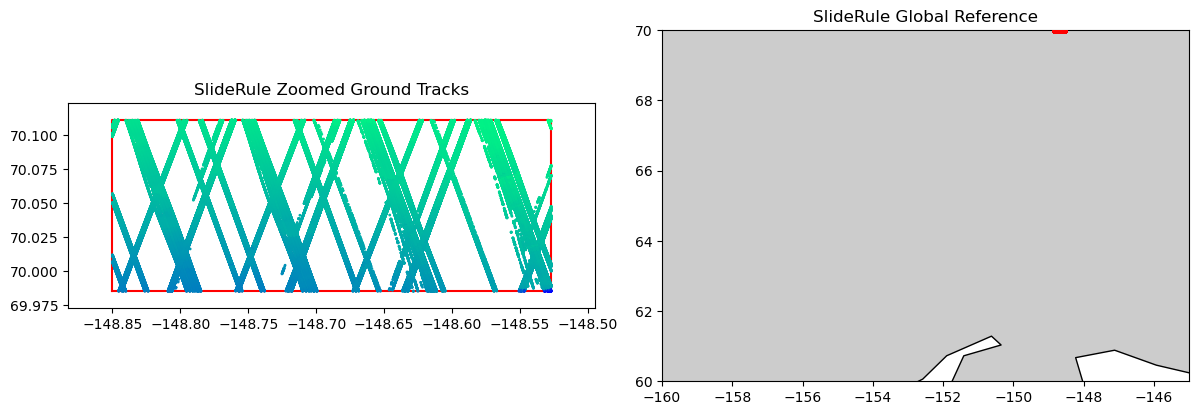

In [6]:
# Sample plot for all of the ICESat-2 tracks since its launch

# Calculate Extent
lons = [p["lon"] for p in region]
lats = [p["lat"] for p in region]
lon_margin = (max(lons) - min(lons)) * 0.1
lat_margin = (max(lats) - min(lats)) * 0.1

# Create Plot
fig,(ax1,ax2) = plt.subplots(num=None, ncols=2, figsize=(12, 6))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
df.plot(ax=ax1, column=df["h_mean"], cmap='winter_r', s=1.0, zorder=3)
ax1.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)
ax1.set_xlim(min(lons) - lon_margin, max(lons) + lon_margin)
ax1.set_ylim(min(lats) - lat_margin, max(lats) + lat_margin)
ax1.set_aspect('equal', adjustable='box')

# Plot SlideRule Global View
ax2.set_title("SlideRule Global Reference")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax2, color='0.8', edgecolor='black')
df.plot(ax=ax2, marker='o', color='red', markersize=2.5, zorder=3)
ax2.set_xlim(-160,-145)
ax2.set_ylim(60,70)
ax2.set_aspect('equal', adjustable='box')

# Show Plot
plt.tight_layout()

In [7]:
# Set up a dataframe that is only applicable for an RGT of interest
rgt = 1097
rgt_pd = df[df['rgt']==rgt]

rgt_pd

,dh_fit_dx,rms_misfit,cycle,h_sigma,pflags,delta_time,spot,gt,rgt,h_mean,w_surface_window_final,distance,dh_fit_dy,n_fit_photons,segment_id,geometry
time,,,,,,,,,,,,,,,,
2019-06-09 02:29:48.785945480,0.000976,0.072859,3,0.003642,0,4.528259e+07,3,30,1097,23.267978,3.0,1.225073e+07,0.0,402,611610,POINT (-148.58649 70.11102)
2019-06-09 02:29:48.787367336,-0.000352,0.085352,3,0.004709,0,4.528259e+07,3,30,1097,23.269836,3.0,1.225074e+07,0.0,339,611611,POINT (-148.58653 70.11093)
2019-06-09 02:29:48.788788840,0.000444,0.094923,3,0.005977,0,4.528259e+07,3,30,1097,23.268693,3.0,1.225075e+07,0.0,266,611611,POINT (-148.58656 70.11084)
2019-06-09 02:29:48.790211792,-0.000835,0.091686,3,0.016188,0,4.528259e+07,3,30,1097,23.264733,3.0,1.225076e+07,0.0,121,611612,POINT (-148.58660 70.11076)
2019-06-09 02:29:48.792684760,0.003730,0.112454,3,0.014886,0,4.528259e+07,3,30,1097,23.317673,3.0,1.225078e+07,0.0,140,611613,POINT (-148.58666 70.11060)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04 02:48:05.514240784,0.000083,0.128654,14,0.019860,0,1.315973e+08,6,60,1097,47.793927,3.0,1.226526e+07,0.0,43,612336,POINT (-148.72035 69.98547)
2022-03-04 02:48:05.515655648,-0.002079,0.142970,14,0.019714,0,1.315973e+08,6,60,1097,47.761587,3.0,1.226527e+07,0.0,53,612337,POINT (-148.72038 69.98538)
2022-03-04 02:48:05.517068736,0.007552,0.121865,14,0.016125,0,1.315973e+08,6,60,1097,47.806663,3.0,1.226528e+07,0.0,59,612337,POINT (-148.72041 69.98529)


<AxesSubplot: >

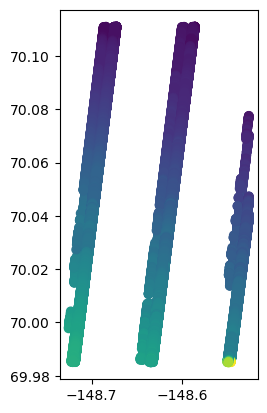

In [8]:
rgt_pd.plot(column='h_mean')

In [9]:
# Save the DataFrame to a CSV file
rgt_pd.to_csv(r'is2_atl03sl_%s_rgt%s.csv' %(field_id, rgt))

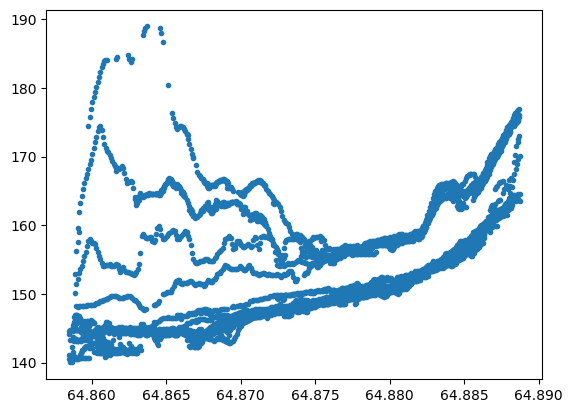

In [26]:
plt.plot(rgt_pd.geometry.y, rgt_pd.h_mean, '.')

In [ ]:
rgt_xr = rgt_pd.to_xarray()